In [1]:
from __future__ import division

# KAGGLE ONLY PURPOSES

2017

Machine Learning Practical

University of Edinburgh

Georgios Pligoropoulos - s1687568

Coursework 4 (part 8)

### Imports, Inits, and helper functions

In [2]:
jupyterNotebookEnabled = True
plotting = True
coursework, part = 4, 8
saving = True

if jupyterNotebookEnabled:
    #%load_ext autoreload
    %reload_ext autoreload
    %autoreload 2

In [3]:
import sys, os
mlpdir = os.path.expanduser(
    '~/pligor.george@gmail.com/msc_Artificial_Intelligence/mlp_Machine_Learning_Practical/mlpractical'
)
sys.path.append(mlpdir)

In [4]:
from collections import OrderedDict
import skopt
from mylibs.jupyter_notebook_helper import show_graph
import datetime
import os
import time
import tensorflow as tf
import numpy as np
from mlp.data_providers import MSD10GenreDataProvider, MSD25GenreDataProvider,\
    MSD10Genre_Autoencoder_DataProvider, MSD10Genre_StackedAutoEncoderDataProvider
import matplotlib.pyplot as plt
from mylibs.batch_norm import fully_connected_layer_with_batch_norm_and_l2
from mylibs.stacked_autoencoder_pretrainer import \
    constructModelFromPretrainedByAutoEncoderStack,\
    buildGraphOfStackedAutoencoder, executeNonLinearAutoencoder
    
from mylibs.jupyter_notebook_helper import getRunTime, getTrainWriter, getValidWriter,\
    plotStats, initStats, gatherStats, renderStatsCollection
    
from mylibs.tf_helper import tfRMSE, tfMSE, fully_connected_layer
    #trainEpoch, validateEpoch

from mylibs.py_helper import merge_dicts

from mylibs.dropout_helper import constructProbs

from mylibs.batch_norm import batchNormWrapper_byExponentialMovingAvg,\
    fully_connected_layer_with_batch_norm
    
import pickle
from skopt.plots import plot_convergence
from mylibs.jupyter_notebook_helper import DynStats
import operator
from skopt.space.space import Integer, Categorical, Real
from skopt import gp_minimize
from rnn.rnn_batch_norm import RNNBatchNorm

if jupyterNotebookEnabled:
    %matplotlib inline

In [5]:
seed = 16011984
rng = np.random.RandomState(seed=seed)

config = tf.ConfigProto(log_device_placement=True, allow_soft_placement=True)
config.gpu_options.allow_growth = True

figcount = 0

tensorboardLogdir = 'tf_cw%d_%d' % (coursework, part)

curDtype = tf.float32

reluBias = 0.1

In [6]:
batch_size = 50
segmentCount = 120
segmentLen = 25

In [7]:
best_params_filename = 'rnn_msd25_best_params.npy'
stats_coll_filename = 'rnn_msd25_bay_opt_stats_coll.npy'
res_gp_save_filename = 'rnn_msd25_res_gp.pickle'
stats_final_run_filename = 'rnn_msd25_final_run_stats.npy'

here the state size is equal to the number of classes because we have given to the last output all the responsibility.

We are going to follow a repetitive process. For example if num_steps=6 then we break the 120 segments into 20 parts

The output of each part will be the genre. We are comparing against the genre every little part 

### MSD 25 genre Bayesian Optimization

In [8]:
num_classes=25

In [9]:
numLens = np.sort(np.unique([2, 3, 4, 5, 6, 8, 10, 12, 15, 20, 24, 30, 40, 60]))
assert np.all( segmentCount % numLens == 0 )
print len(numLens)
numLens

14


array([ 2,  3,  4,  5,  6,  8, 10, 12, 15, 20, 24, 30, 40, 60])

In [10]:
rnnModel = RNNBatchNorm(batch_size=batch_size, rng=rng, dtype = curDtype, config=config,
                      segment_count=segmentCount, segment_len= segmentLen, num_classes=num_classes)

In [11]:
#it cannot accept global variables for some unknown reason ...
def objective(params): # Here we define the metric we want to minimise    
    (state_size, num_steps, learning_rate) = params
    
    epochs = 20
    
    stats, keys = rnnModel.run_rnn(state_size = state_size, num_steps=num_steps, epochs = epochs, 
                                  learning_rate = learning_rate)
    
    #save everytime in case it crashes
    filename = stats_coll_filename
    statsCollection = np.load(filename)[()] if os.path.isfile(filename) else dict()
    statsCollection[(state_size, num_steps, learning_rate)] = stats
    np.save(filename, statsCollection)
    
    if plotting:
        fig_1, ax_1, fig_2, ax_2 = plotStats(stats, keys)
        plt.show()
    
    # We want to maximise validation accuracy, i.e. minimise minus validation accuracy
    validAccs = stats[:, -1]
    length10percent = max(len(validAccs) // 10, 1)
    best10percent = np.sort(validAccs)[-length10percent:]
    return -np.mean(best10percent)
    #return -max(stats[:, -1])

In [12]:
#it cannot accept global variables for some unknown reason ...
def objective_min_epochs(params): # Here we define the metric we want to minimise    
    (state_size, num_steps, learning_rate) = params
    
    targetValidAcc = 0.23
    maxEpochs = 20
    
    stats, metric = rnnModel.run_until(targetValidAcc = targetValidAcc, maxEpochs=maxEpochs,
                                       learning_rate=learning_rate, num_steps=num_steps, state_size =state_size)

    
    #save everytime in case it crashes
    filename = stats_coll_filename
    statsCollection = np.load(filename)[()] if os.path.isfile(filename) else dict()
    statsCollection[(state_size, num_steps, learning_rate)] = stats
    np.save(filename, statsCollection)
    
    if plotting:
        fig_1, ax_1, fig_2, ax_2 = plotStats(stats, DynStats.keys)
        plt.show()
    
    # We want to minimize the amount of epochs required to reach 23% accuracy
    return metric

In [13]:
stateSizeSpace = Integer(15, 1000)
numStepSpace = Categorical(numLens)
learningRateSpace = Real(1e-6, 1e-1, prior="log-uniform")
space  = [stateSizeSpace, numStepSpace, learningRateSpace]

In [14]:
if jupyterNotebookEnabled:
    %%time

if not os.path.isfile(best_params_filename):
    if os.path.isfile(stats_coll_filename):
        os.remove(stats_coll_filename)
    
    res_gp = gp_minimize(
            func=objective_min_epochs, # function that we wish to minimise
            dimensions=space, #the search space for the hyper-parameters
            #x0=x0, #inital values for the hyper-parameters
            n_calls=25, #number of times the function will be evaluated
            random_state = seed, #random seed
            n_random_starts=5,
                #before we start modelling the optimised function with a GP Regression
                #model, we want to try a few random choices for the hyper-parameters.
            kappa=1.9 #trade-off between exploration vs. exploitation.
        )

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.06 µs


In [15]:
if os.path.isfile(best_params_filename):
    best_params = np.load(best_params_filename)
else:
    np.save(best_params_filename, res_gp.x)
    best_params = res_gp.x

In [16]:
if os.path.isfile(res_gp_save_filename):
    with open(res_gp_save_filename) as f:  # Python 3: open(..., 'rb')
        (res_gp, ) = pickle.load(f)
else:
    with open(res_gp_save_filename, 'w') as f:  # Python 3: open(..., 'wb')
        pickle.dump([res_gp], f)

In [17]:
best_params

array([  1.67000000e+02,   1.00000000e+01,   6.76306414e-04])

### Bayesian Optimization Plots

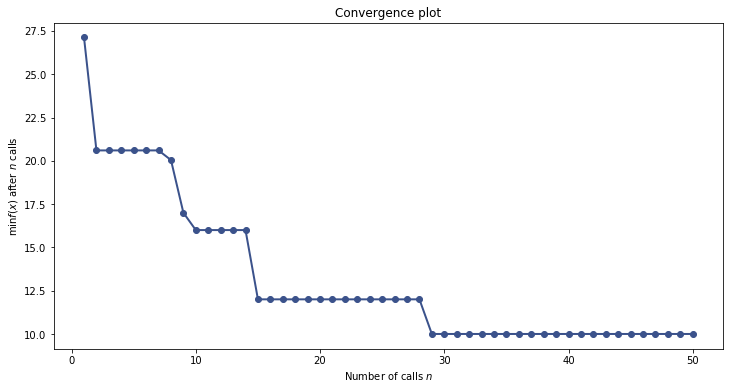

In [18]:
if plotting:
    fig = plt.figure(figsize=(12,6))
    plot_convergence(res_gp)
    plt.grid()
    plt.show()
    if saving:
        fig.savefig('cw{}_part{}_fig_{}.svg'.format(coursework, part, "convergence plot"))

/home/studenthp/anaconda2/envs/mlp/lib/python2.7/site-packages/ipykernel/__main__.py:3: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  app.launch_new_instance()
/home/studenthp/anaconda2/envs/mlp/lib/python2.7/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/studenthp/anaconda2/envs/mlp/lib/python2.7/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")
/home/studenthp/anaconda2/envs/mlp/lib/python2.7/site-packages/ipykernel/__main__.py:9: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands 

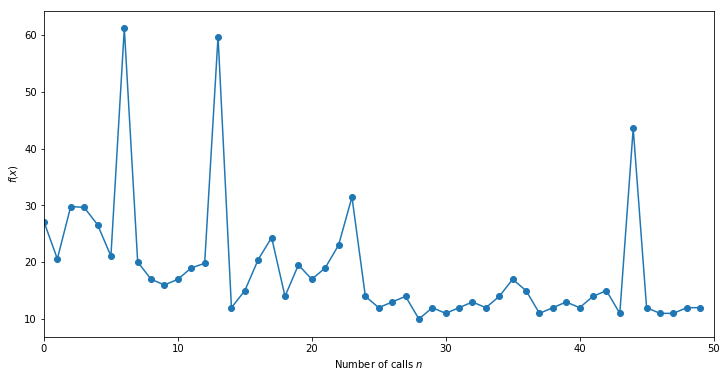

In [19]:
if plotting:
    fig = plt.figure(figsize=(12,6))
    plt.hold(True)
    plt.plot(res_gp.func_vals)
    plt.scatter(range(len(res_gp.func_vals)), res_gp.func_vals)
    plt.ylabel(r'$f(x)$')
    plt.xlabel('Number of calls $n$')
    plt.xlim([0, len(res_gp.func_vals)])
    plt.hold(False)
    plt.show()
    if saving:
        fig.savefig('cw{}_part{}_fig_{}.svg'.format(coursework, part, "objective_function"))

### Experiment with Best Parameters

In [20]:
best_params = np.load(best_params_filename)
best_params

array([  1.67000000e+02,   1.00000000e+01,   6.76306414e-04])

In [21]:
(state_size, num_steps, learning_rate) = best_params
state_size = int(state_size) 
num_steps = int(num_steps)
(state_size, num_steps, learning_rate)

(167, 10, 0.00067630641402046169)

In [22]:
num_classes = 25

In [23]:
rnnModel = RNNBatchNorm(batch_size=batch_size, rng=rng, dtype = curDtype, config=config, num_classes=num_classes,
                      segment_count=segmentCount, segment_len= segmentLen,)

epochs: 100
rnn steps: 10
state size: 167
data_provider is divided exactly by batch size
End epoch 01 (105.195 secs): err(train)=2.74, acc(train)=0.18, err(valid)=2.77, acc(valid)=0.17, 
data_provider is divided exactly by batch size
End epoch 02 (104.494 secs): err(train)=2.66, acc(train)=0.20, err(valid)=2.71, acc(valid)=0.18, 
data_provider is divided exactly by batch size
End epoch 03 (107.722 secs): err(train)=2.63, acc(train)=0.21, err(valid)=2.69, acc(valid)=0.20, 
End epoch 04 (104.542 secs): err(train)=2.60, acc(train)=0.22, err(valid)=2.69, acc(valid)=0.19, 
data_provider is divided exactly by batch size
End epoch 05 (104.269 secs): err(train)=2.57, acc(train)=0.22, err(valid)=2.62, acc(valid)=0.21, 
data_provider is divided exactly by batch size
End epoch 06 (104.394 secs): err(train)=2.55, acc(train)=0.23, err(valid)=2.61, acc(valid)=0.21, 
data_provider is divided exactly by batch size
End epoch 07 (105.339 secs): err(train)=2.52, acc(train)=0.23, err(valid)=2.61, acc(vali

/home/studenthp/pligor.george@gmail.com/msc_Artificial_Intelligence/mlp_Machine_Learning_Practical/mlpractical/mylibs/jupyter_notebook_helper.py:74: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax_1.hold(True)
/home/studenthp/pligor.george@gmail.com/msc_Artificial_Intelligence/mlp_Machine_Learning_Practical/mlpractical/mylibs/jupyter_notebook_helper.py:78: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax_1.hold(False)
/home/studenthp/pligor.george@gmail.com/msc_Artificial_Intelligence/mlp_Machine_Learning_Practical/mlpractical/mylibs/jupyter_notebook_helper.py:87: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax_2.hold(True)
/home/studenthp/pligor.george@gma

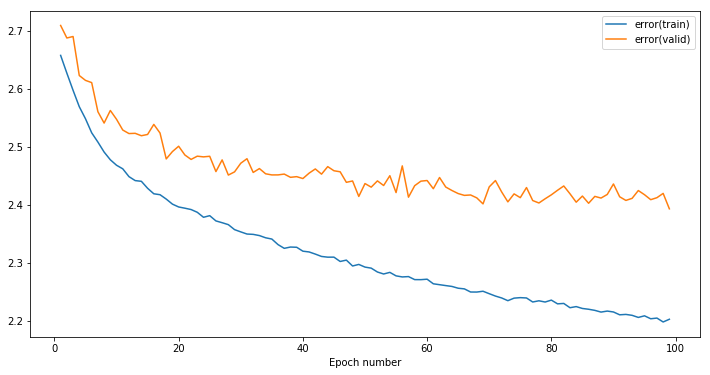

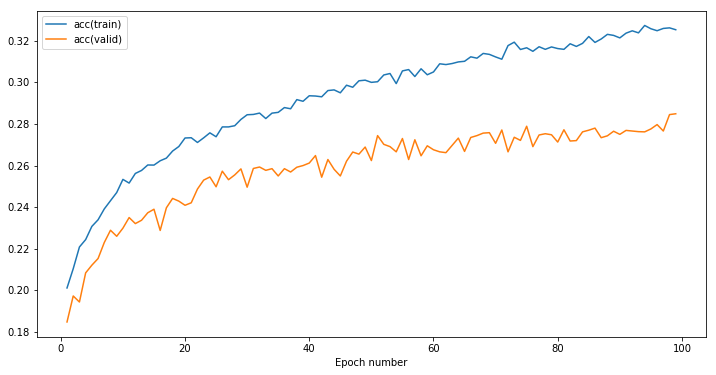

0.284899991341
CPU times: user 3h 29min 46s, sys: 7min 59s, total: 3h 37min 46s
Wall time: 3h 5min 53s


In [24]:
%%time

epochs = 100

stats, keys = rnnModel.run_rnn(state_size = state_size, num_steps=num_steps,
                               learning_rate = learning_rate,
                               epochs = epochs, kaggleEnabled = True)

if plotting:
    fig_1, ax_1, fig_2, ax_2 = plotStats(stats, keys)
    plt.show()
    if saving:
        fig_1.savefig('cw%d_part%d_fig_error.svg' % (coursework, part))
        fig_2.savefig('cw%d_part%d_fig_valid.svg' % (coursework, part))
        np.save(stats_final_run_filename, stats)

print max(stats[:, -1]) #maximum validation accuracy